# scRNA-seq Example
Examples to use ``GSEApy`` for scRNA-seq data

In [1]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

In [2]:
import gseapy as gp
import scanpy as sc

In [3]:
gp.__version__

'1.0.2'

### Read Demo Data

In [4]:
adata = sc.read_h5ad("data/ifnb.h5ad") # data from SeuratData::ifnb

In [5]:
adata.obs.head()

,orig.ident,nCount_RNA,nFeature_RNA,stim,seurat_annotations
AAACATACATTTCC.1,IMMUNE_CTRL,3017.0,877,CTRL,CD14 Mono
AAACATACCAGAAA.1,IMMUNE_CTRL,2481.0,713,CTRL,CD14 Mono
AAACATACCTCGCT.1,IMMUNE_CTRL,3420.0,850,CTRL,CD14 Mono
AAACATACCTGGTA.1,IMMUNE_CTRL,3156.0,1109,CTRL,pDC
AAACATACGATGAA.1,IMMUNE_CTRL,1868.0,634,CTRL,CD4 Memory T


In [6]:
adata.layers['counts'] = adata.X # Save raw counts

In [7]:
# preprocessing
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.layers['lognorm'] = adata.X

In [8]:
adata.obs.groupby('seurat_annotations')['stim'].value_counts()

seurat_annotations  stim
B                   STIM     571
                    CTRL     407
B Activated         STIM     203
                    CTRL     185
CD14 Mono           CTRL    2215
                    STIM    2147
CD16 Mono           STIM     537
                    CTRL     507
CD4 Memory T        STIM     903
                    CTRL     859
CD4 Naive T         STIM    1526
                    CTRL     978
CD8 T               STIM     462
                    CTRL     352
DC                  CTRL     258
                    STIM     214
Eryth               STIM      32
                    CTRL      23
Mk                  STIM     121
                    CTRL     115
NK                  STIM     321
                    CTRL     298
T activated         STIM     333
                    CTRL     300
pDC                 STIM      81
                    CTRL      51
Name: stim, dtype: int64

In [9]:
# set STIM as class 0, CTRL as class 1, to make categorical
adata.obs['stim'] = pd.Categorical(adata.obs['stim'], categories=["STIM", "CTRL"], ordered=True)
indices = adata.obs.sort_values(['seurat_annotations', 'stim']).index
adata = adata[indices,:]

In [10]:
# # # subset and write GCT and CLS file
# outdir = "ifnb/"
# for cell in adata.obs.seurat_annotations.unique():
#     bdata = adata[adata.obs.seurat_annotations == cell ]
#     groups = bdata.obs['stim'].to_list()
#     cls_dict = bdata.obs['stim'].to_dict()
#     gs = bdata.to_df().T
#     gs.index.name = "NAME"
    
#     gs_std = gs.groupby(by=cls_dict, axis=1).std()
#     gs = gs[gs_std.sum(axis=1) > 0]
#     gs= gs + 1e-08  # we don't like zeros!!!
    
#     gs.insert(0, column="Description", value=cell,)
#     outname = os.path.join( outdir, cell + ".gct")
#     outcls = os.path.join(outdir, cell +".cls")
#     s_len = gs.shape[1] - 1
#     with open(outname,"w") as correct:
#         line1="#1.2\n"+f"{gs.shape[0]}\t{s_len}\n"
#         correct.write(line1)
#         gs.to_csv(correct, sep="\t")
        
#     with open(outcls, "w") as cl:
#         line = f"{len(groups)} 2 1\n# STIM CTRL\n"
#         cl.write(line)
#         cl.write(" ".join(groups) + "\n")
#     print(outname)

In [11]:
# subset data
bdata = adata[adata.obs.seurat_annotations == "CD14 Mono"].copy()
bdata

AnnData object with n_obs × n_vars = 4362 × 14053
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'stim', 'seurat_annotations'
    var: 'features'
    uns: 'log1p'
    layers: 'counts', 'lognorm'

### GSEA

In [12]:
import time
t1 = time.time()
res = gp.gsea(data=bdata.to_df().T, # row -> genes, column-> samples
        gene_sets="GO_Biological_Process_2021",
        cls=bdata.obs.stim,
        permutation_num=1000,
        permutation_type='phenotype', 
        outdir=None,
        method='s2n', # signal_to_noise
        threads= 16)
t2=time.time()
print(t2-t1)

64.49783539772034


In [13]:
res.res2d.head(10)

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,gsea,cytokine-mediated signaling pathway (GO:0019221),0.685491,3.759972,0.0,0.0,0.0,140/490,9.03%,ISG15;IFIT3;IFIT1;RSAD2;ISG20;CXCL10;IFITM3;CX...
1,gsea,innate immune response (GO:0045087),0.784391,3.66143,0.0,0.0,0.0,56/188,6.30%,ISG15;IFIT1;CXCL10;IFITM3;APOBEC3A;MX1;IFI6;OA...
2,gsea,regulation of immune response (GO:0050776),0.759354,3.549856,0.0,0.0,0.0,49/140,8.77%,RSAD2;IRF7;PLSCR1;HERC5;IL4I1;SLAMF7;IFITM1;HL...
3,gsea,defense response to virus (GO:0051607),0.903464,3.438759,0.0,0.0,0.0,42/108,2.85%,ISG15;IFIT3;IFIT1;RSAD2;ISG20;CXCL10;IFITM3;AP...
4,gsea,response to cytokine (GO:0034097),0.718931,3.37735,0.0,0.0,0.0,37/120,7.26%,ISG15;IFITM3;MX1;IFITM2;PLSCR1;MX2;BST2;EIF2AK...
5,gsea,defense response to symbiont (GO:0140546),0.904717,3.362051,0.0,0.0,0.0,49/100,4.90%,ISG15;IFIT3;IFIT1;RSAD2;ISG20;IFITM3;APOBEC3A;...
6,gsea,cellular response to interferon-gamma (GO:0071...,0.792726,3.327923,0.0,0.0,0.0,49/99,7.18%,CCL8;OAS1;MT2A;OASL;IRF7;GBP1;GBP4;CCL2;OAS3;O...
7,gsea,regulation of interferon-beta production (GO:0...,0.856704,3.259412,0.0,0.0,0.0,14/44,4.94%,ISG15;OAS1;IRF7;DDX58;IFIH1;OAS3;OAS2;DHX58;HS...
8,gsea,"RNA splicing, via transesterification reaction...",-0.626583,-3.225436,0.0,0.0,0.0,128/234,19.45%,YBX1;PABPC1;HNRNPA1;DDX5;SRSF9;HNRNPM;RBMX;SF3...
9,gsea,gene expression (GO:0010467),-0.70455,-3.219153,0.0,0.0,0.0,134/322,10.13%,RPL6;RPL7;RPL15;RPL10;RPS3A;RPS6;RPL8;RPL21;RP...


In [14]:
res.ranking.shape # raking metric

(13216,)

<AxesSubplot:title={'center':'regulation of interferon-beta production (GO:0032648)'}>

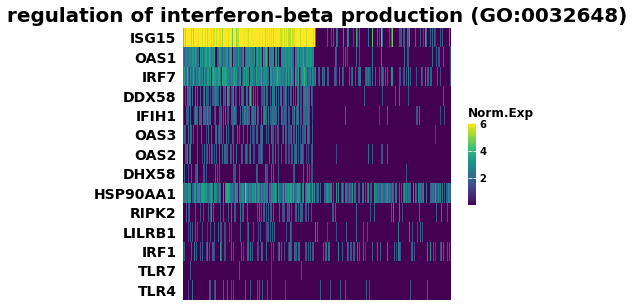

In [15]:
## Heatmap of gene expression
i = 7
genes = res.res2d.Lead_genes.iloc[i].split(";")
gp.heatmap(df = res.heatmat.loc[genes], 
           z_score=None, 
           title=res.res2d.Term.iloc[i], 
           figsize=(6,5), 
           cmap=plt.cm.viridis, 
           xticklabels=False)

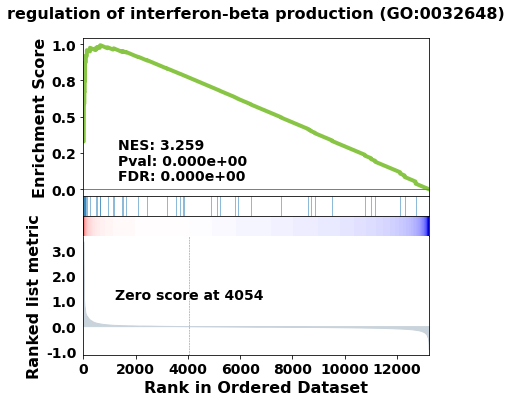

In [16]:
term = res.res2d.Term.iloc[i]
gp.gseaplot(res.ranking, term=term, **res.results[term])

### DEG Analysis

In [17]:
# find degs 
sc.tl.rank_genes_groups(bdata, 
                        groupby='stim', 
                        use_raw=False, 
                        layer='lognorm',
                        method='wilcoxon', 
                        groups=["STIM"], 
                        reference='CTRL')

... storing 'orig.ident' as categorical
... storing 'seurat_annotations' as categorical


In [18]:
bdata.X.max() # already log1p

8.065909516515664

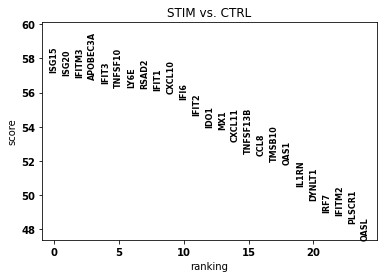

In [19]:
sc.pl.rank_genes_groups(bdata, n_genes=25, sharey=False)

In [20]:
# get deg result
result = bdata.uns['rank_genes_groups']
groups = result['names'].dtype.names
degs = pd.DataFrame(
    {group + '_' + key: result[key][group]
    for group in groups for key in ['names','scores', 'pvals','pvals_adj','logfoldchanges']})

In [21]:
degs.head()

,STIM_names,STIM_scores,STIM_pvals,STIM_pvals_adj,STIM_logfoldchanges
0,ISG15,57.165920,0.0,0.0,8.660480
1,ISG20,57.010372,0.0,0.0,6.850681
2,IFITM3,56.890392,0.0,0.0,6.320490
3,APOBEC3A,56.770397,0.0,0.0,6.616682
4,IFIT3,56.569122,0.0,0.0,8.313443


In [22]:
degs.shape

(14053, 5)

### Over-representation analysis (Enrichr API)

In [23]:
# subset up or down regulated genes
degs_sig = degs[degs.STIM_pvals_adj < 0.05]
degs_up = degs_sig[degs_sig.STIM_logfoldchanges > 0]
degs_dw = degs_sig[degs_sig.STIM_logfoldchanges < 0]

In [24]:
degs_up.shape

(687, 5)

In [25]:
degs_dw.shape

(1030, 5)

In [26]:
# Enricr API
enr_up = gp.enrichr(degs_up.STIM_names, 
                    gene_sets='GO_Biological_Process_2021', 
                    outdir=None)

In [27]:
# trim (go:...)
enr_up.res2d.Term = enr_up.res2d.Term.str.split(" \(GO").str[0]

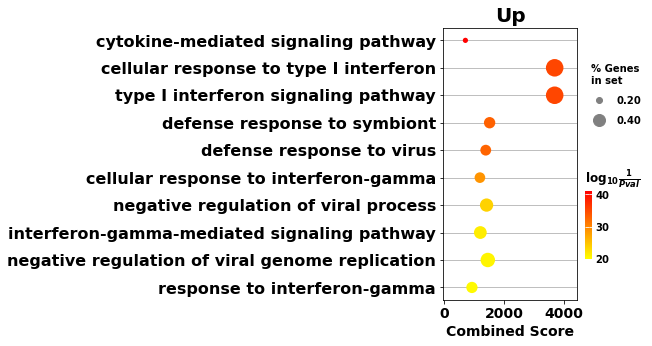

In [28]:
# dotplot
gp.dotplot(enr_up.res2d, figsize=(3,5), title="Up", cmap = plt.cm.autumn_r)
plt.show()

In [29]:
enr_dw = gp.enrichr(degs_dw.STIM_names, 
                    gene_sets='GO_Biological_Process_2021', 
                    outdir=None)

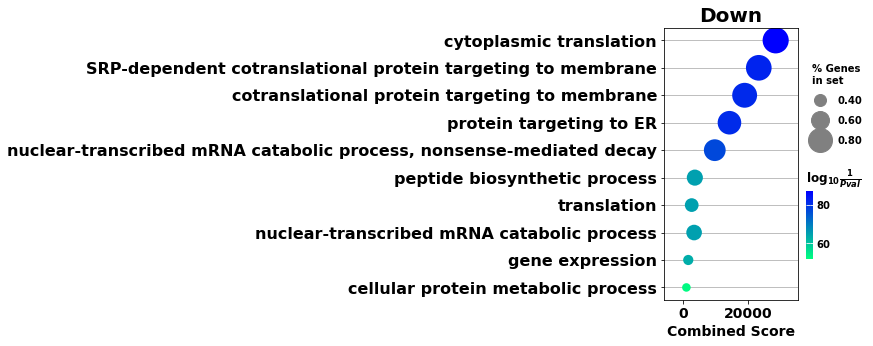

In [30]:
enr_dw.res2d.Term = enr_dw.res2d.Term.str.split(" \(GO").str[0]
gp.dotplot(enr_dw.res2d, 
           figsize=(3,5), 
           title="Down", 
           cmap = plt.cm.winter_r, 
           size=5)
plt.show()

In [31]:
# concat results
enr_up.res2d['UP_DW'] = "UP"
enr_dw.res2d['UP_DW'] = "DOWN"
enr_res = pd.concat([enr_up.res2d.head(), enr_dw.res2d.head()]) 

In [32]:
from gseapy.scipalette import SciPalette
sci = SciPalette()
NbDr = sci.create_colormap()
# NbDr

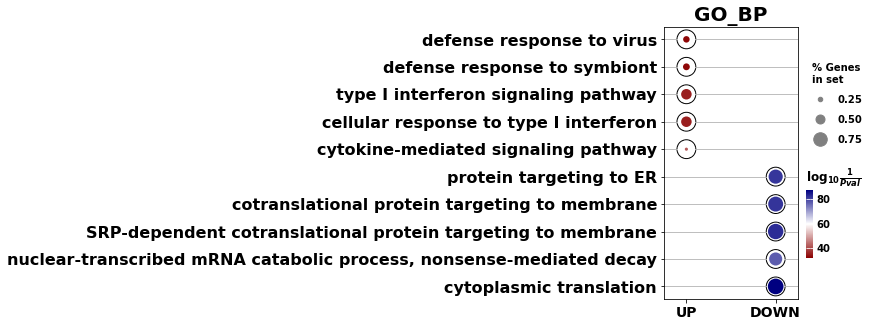

In [33]:
# display multi-datasets
ax = gp.dotplot(enr_res,figsize=(3,5), 
                x='UP_DW', 
                x_order = ["UP","DOWN"], 
                title="GO_BP", 
                cmap = NbDr.reversed(), 
                size=3, 
                show_ring=True)
ax.set_xlabel("")
plt.show()

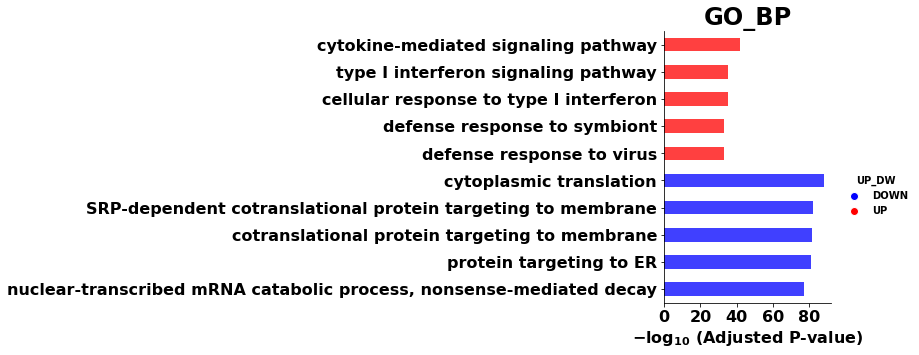

In [34]:
ax = gp.barplot(enr_res, figsize=(3,5), 
                group ='UP_DW', 
                title ="GO_BP", 
                color = ['b','r'])              

### Network Visualization

In [35]:
import networkx as nx

In [36]:
res.res2d.head()

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,gsea,cytokine-mediated signaling pathway (GO:0019221),0.685491,3.759972,0.0,0.0,0.0,140/490,9.03%,ISG15;IFIT3;IFIT1;RSAD2;ISG20;CXCL10;IFITM3;CX...
1,gsea,innate immune response (GO:0045087),0.784391,3.66143,0.0,0.0,0.0,56/188,6.30%,ISG15;IFIT1;CXCL10;IFITM3;APOBEC3A;MX1;IFI6;OA...
2,gsea,regulation of immune response (GO:0050776),0.759354,3.549856,0.0,0.0,0.0,49/140,8.77%,RSAD2;IRF7;PLSCR1;HERC5;IL4I1;SLAMF7;IFITM1;HL...
3,gsea,defense response to virus (GO:0051607),0.903464,3.438759,0.0,0.0,0.0,42/108,2.85%,ISG15;IFIT3;IFIT1;RSAD2;ISG20;CXCL10;IFITM3;AP...
4,gsea,response to cytokine (GO:0034097),0.718931,3.37735,0.0,0.0,0.0,37/120,7.26%,ISG15;IFITM3;MX1;IFITM2;PLSCR1;MX2;BST2;EIF2AK...


In [37]:
# res.res2d.to_csv("data/test.out.txt", sep="\t", index=False)

In [38]:
nodes, edges = gp.enrichment_map(res.res2d)

In [39]:
nodes.head()

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes,p_inv,Hits_ratio
node_idx,,,,,,,,,,,,
0,gsea,gene expression (GO:0010467),-0.70455,-3.219153,0.0,0.000009,0.0,134/322,10.13%,RPL6;RPL7;RPL15;RPL10;RPS3A;RPS6;RPL8;RPL21;RP...,5.061359,0.416149
1,gsea,"RNA splicing, via transesterification reaction...",-0.626583,-3.225436,0.0,0.000009,0.0,128/234,19.45%,YBX1;PABPC1;HNRNPA1;DDX5;SRSF9;HNRNPM;RBMX;SF3...,5.061359,0.547009
2,gsea,regulation of interferon-beta production (GO:0...,0.856704,3.259412,0.0,0.000009,0.0,14/44,4.94%,ISG15;OAS1;IRF7;DDX58;IFIH1;OAS3;OAS2;DHX58;HS...,5.061359,0.318182
3,gsea,cellular response to interferon-gamma (GO:0071...,0.792726,3.327923,0.0,0.000009,0.0,49/99,7.18%,CCL8;OAS1;MT2A;OASL;IRF7;GBP1;GBP4;CCL2;OAS3;O...,5.061359,0.494949
4,gsea,defense response to symbiont (GO:0140546),0.904717,3.362051,0.0,0.000009,0.0,49/100,4.90%,ISG15;IFIT3;IFIT1;RSAD2;ISG20;IFITM3;APOBEC3A;...,5.061359,0.490000


In [40]:
edges.head()

,src_idx,targ_idx,src_name,targ_name,jaccard_coef,overlap_coef,overlap_genes
0,0,1,gene expression (GO:0010467),"RNA splicing, via transesterification reaction...",0.110169,0.203125,"EIF4A3,POLR2B,U2AF1,HNRNPU,CDC40,POLR2L,SRRM1,..."
1,0,8,gene expression (GO:0010467),cellular macromolecule biosynthetic process (G...,0.645390,0.928571,"PABPC4,RPL15,RPL24,RPS20,POLR2F,RPS27,MRPS12,R..."
2,1,8,"RNA splicing, via transesterification reaction...",cellular macromolecule biosynthetic process (G...,0.022624,0.051020,"POLR2E,POLR2J,POLR2G,POLR2L,POLR2F"
3,2,3,regulation of interferon-beta production (GO:0...,cellular response to interferon-gamma (GO:0071...,0.105263,0.428571,"OAS2,OAS1,TLR4,OAS3,IRF1,IRF7"
4,2,4,regulation of interferon-beta production (GO:0...,defense response to symbiont (GO:0140546),0.188679,0.714286,"OAS2,IFIH1,OAS1,ISG15,OAS3,LILRB1,TLR7,DDX58,I..."


In [41]:
# build graph
G = nx.from_pandas_edgelist(edges, 
                            source='src_idx', 
                            target='targ_idx', 
                            edge_attr=['jaccard_coef', 'overlap_coef', 'overlap_genes'])

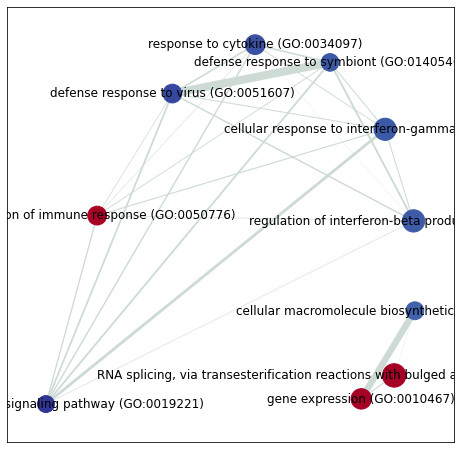

In [42]:
fig, ax = plt.subplots(figsize=(8, 8))

# init node cooridnates
pos=nx.layout.spiral_layout(G)
#node_size = nx.get_node_attributes()
# draw node
nx.draw_networkx_nodes(G, 
                       pos=pos, 
                       cmap=plt.cm.RdYlBu, 
                       node_color=list(nodes.NES),
                       node_size=list(nodes.Hits_ratio *1000))
# draw node label
nx.draw_networkx_labels(G, 
                        pos=pos, 
                        labels=nodes.Term.to_dict())
# draw edge
edge_weight = nx.get_edge_attributes(G, 'jaccard_coef').values()
nx.draw_networkx_edges(G, 
                       pos=pos, 
                       width=list(map(lambda x: x*10, edge_weight)), 
                       edge_color='#CDDBD4')
plt.show()